In [277]:
import sklearn.datasets as datasets
import pandas as pd
import random
import csv
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO  
from sklearn.model_selection import cross_val_score
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import statistics
import math
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 1. Partición de datos

Particionar el conjunto de datos en entrenamiento, validación y test. El conjunto de test
se deberá dejar apartado para ser utilizado al final.

In [278]:
# importa el dataset
data = pd.read_csv('Dataset_DesempeñoAcademico.csv')

In [279]:
# reemplaza los valores categóricos del target por una variable dummy
# High pasa a ser 1 y Low y Medium pasan a ser 0
cleanup_nums = {"Class":{"H": 1, "L": 0, "M": 0}}
data.replace(cleanup_nums, inplace=True)

In [280]:
# lista de columnas numéricas
number_columns = ['raisedhands','VisITedResources','AnnouncementsView','Discussion']

In [281]:
# quita columnas numéricas del dataset y columna target
data_nominal = data.drop(columns=number_columns)
data_nominal = data_nominal.drop(columns=['Class'])

In [282]:
# función que genera una lista de listas a partir de un df
# cada lista es una fila del dataframe
def generate_matriz2transform(df2transform):
    a = []
    for i in range(len(df2transform)):
        a.append(list(df2transform.loc[i,:]))
    return a

In [283]:
# instancia la funcion generate_matriz2transform con el df con categorías nominales
matriz = generate_matriz2transform(data_nominal)

In [284]:
# función que extrae la lista de valores de los atributos nominales de un df y los guarda en un diccionario
# toma como parámetro el df del cual se extraerán dichos atributos
# output: {'genre': ['F','M'], 'Relation':['Father','Mother'],...}
def get_attributes(nominalDF):
    dict_attributes = dict()
    for c in nominalDF.columns:
        dict_attributes[c]=list(pd.unique(nominalDF[c]))
    return dict_attributes

In [285]:
# instancia la funcion get_attributes con el df con categorías nominales
# tomando en cuenta todas sus filas y todas las columnas
dict_attributes = get_attributes(data_nominal)

In [286]:
# función que transforma una matriz con atributos nominales en una matriz con atributos numéricos
# toma como parámetros la matriz a transformar y un diccionario con los atributos y sus posibles valores
def transform_matriz(matriz2transform, attributes2transform):
    transformed_rows = list()
    label_encoders = list()
    # para cada atributo en el diccionario de atributos
    for attribute in attributes2transform.keys():
        # genera un objeto LabelEncoder
        le = preprocessing.LabelEncoder()
        # lo entrena con los valores de ese atributo
        le.fit(attributes2transform[attribute])
        # y lo agrega a la lista de encoders
        label_encoders.append(le)
    # para cada fila de la matriz a transformar
    for i in range(len(matriz2transform)):
        converted = list()
        # para cada l en el rango de 0 a la cantidad de encoders
        for l in range(len(label_encoders)):
            # convierte con el encoder l la palabra en la posición l
            conv = label_encoders[l].transform(matriz2transform[i][l:l+1])[0]
            # agrega la conversión a la lista de convertido
            converted.append(conv)
        # agrega la fila con los valores convertidos a la lista
        transformed_rows.append(converted)
    # devuelve la lista de todas las filas convertidas
    return transformed_rows

In [287]:
# instancia la función transform_matriz con la matriz para transformar
c = transform_matriz(matriz, dict_attributes)

In [288]:
# pasa la matriz a un df y le asigna nombre a sus columnas
df = pd.DataFrame(c, columns=data_nominal.columns)

In [289]:
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays
0,1,4,4,2,1,0,7,0,0,1,1,1
1,1,4,4,2,1,0,7,0,0,1,1,1
2,1,4,4,2,1,0,7,0,0,0,0,0
3,1,4,4,2,1,0,7,0,0,0,0,0
4,1,4,4,2,1,0,7,0,0,0,0,0


In [290]:
# función que agrega agrega columnas numéricas de un df a otro
# toma como parámetros el df al cual se le agregan columnas, el df del cual se copian las columnas y una lista
# con los nombres de las columnas a copiar
def aggregate_num_columns(df2agg, df_WithNumColumns, num_columns):
    for c in num_columns:
        df2agg[c] = df_WithNumColumns[c]
    return df2agg

In [291]:
# instancia la funcion aggregate_num_columns con:
# 1) el df (data frame con atributos nominales convertidos a números),
# 2) el data (data frame desde donde extraer el columnas numéricas),
# 3) la lista number_columns que contiene los nombres de las columnas numéricas
df = aggregate_num_columns(df, data, number_columns)

In [292]:
# vector con el target del dataset
y = data['Class']

In [293]:
# DESARROLLO: train_X, train_y   --->   queda dividirlo en training y validation
# HELD-OUT: test_X, test_y
desarrollo_X, heldout_X, desarrollo_y, heldout_y = train_test_split(df, y, 
                                                        train_size=0.75,
                                                        test_size=0.25,
                                                        random_state=123)

In [294]:
# función que, a partir de un desarrollo X y un desarrollo y, genera una lista con un diccionario por fold
# cada diccionario contiene un training_X y un training_y, y un validation_X y un validation_y
# la validación de cada diccionario no está contenida en el set de training del mismo diccionario
# por lo que se generan sets de validaciones disjuntas
def gen_train_n_validation(df_desarrollo_X, df_desarrollo_y, folds):
    train_n_validation = list()
    n = len(df_desarrollo_X)//folds
    s = 0
    e = n
    for i in range(folds):
        entry = dict()
        entry['training_X'] = df_desarrollo_X.drop(df_desarrollo_X.index[s:e])
        entry['validation_X'] = df_desarrollo_X[s:e]
        entry['training_y'] = df_desarrollo_y.drop(df_desarrollo_y.index[s:e])
        entry['validation_y'] = df_desarrollo_y[s:e]
        train_n_validation.append(entry)
        s += n
        e += n
    return train_n_validation

In [295]:
# instancia la fución para generar set de entrenamiento y validación
# con un set de desarrollo_X, un set de desarrollo_y y un parámetro folds=5
folds = gen_train_n_validation(desarrollo_X,desarrollo_y,5)

## 2. Árboles de decisión

1. Entrenar un árbol de decisión con altura 3 y el resto de los hiperparámetros con su valor en default. Estimar la performance del modelo utilizando 5-fold cross validation utilizando el Accuracy y ROC AUC. Informar:
 - para cada fold el Accuracy y ROC AUC para
     - Conjunto de entrenamiento
     - Conjunto de validación
     - Promedio y desviación estándar de:
         - todos los conjuntos de entrenamiento
         - todos los conjuntos de validación

In [296]:
# función que entrena un arbol de decisión por cada fold, lo testea con el entrenamiento y la validación 
# toma como parámetro una lista con los folds
# devuelve como output una tripla con una matriz con las métricas para cada fold,
# una segunda matriz con medias y desvíos de esas métricas
# y un diccionario con métricas de TPR y FPR para graficar curva de ROC
def decision_tree(fold_list):
    metricas = pd.DataFrame()
    mean_n_std = pd.DataFrame()
    accuracy = {'train':[],'val':[]}
    roc_auc = {'train':[],'val':[]}
    # para cada fold
    for i in range(len(fold_list)):
        # entrenamiento del árbol
        dtree=DecisionTreeClassifier(max_depth=3)
        dtree.fit(fold_list[i]['training_X'], fold_list[i]['training_y'])
        # accuracy para entrenamiento
        predictions_train = dtree.predict(fold_list[i]['training_X'])
        accuracy_train = accuracy_score(fold_list[i]['training_y'], predictions_train)
        metricas.loc['Accuracy Train','fold '+str(i+1)] = accuracy_train
        # accuracy para validación
        predictions_val = dtree.predict(fold_list[i]['validation_X'])
        accuracy_val = accuracy_score(fold_list[i]['validation_y'], predictions_val)
        metricas.loc['Accuracy Val','fold '+str(i+1)] = accuracy_val
        # ROC AUC para entrenamiento
        roc_auc_train = roc_auc_score(fold_list[i]['training_y'], predictions_train)
        metricas.loc['ROC AUC Score Train','fold '+str(i+1)] = roc_auc_train
        # ROC AUC para validación
        roc_auc_val = roc_auc_score(fold_list[i]['validation_y'], predictions_val)
        metricas.loc['ROC AUC Score Val','fold '+str(i+1)] = roc_auc_val
        # alamacena accuracy y métricas de ROC AUC en listas para luego calcular media y desvío
        accuracy['train'].append(accuracy_train)
        accuracy['val'].append(accuracy_val)
        roc_auc['train'].append(roc_auc_train)
        roc_auc['val'].append(roc_auc_val)
    # matriz con medias y desvíos
    mean_n_std.loc['Accuracy - Train', 'Media'] = mean(accuracy['train'])
    mean_n_std.loc['Accuracy - Train', 'Desvío'] = std(accuracy['train'])
    mean_n_std.loc['Accuracy - Val', 'Media'] = mean(accuracy['val'])
    mean_n_std.loc['Accuracy - Val', 'Desvío'] = std(accuracy['val'])
    mean_n_std.loc['ROC AUC Score - Train', 'Media'] = mean(roc_auc['train'])
    mean_n_std.loc['ROC AUC Score - Train', 'Desvío'] = std(roc_auc['train'])
    mean_n_std.loc['ROC AUC Score - Val', 'Media'] = mean(roc_auc['val'])
    mean_n_std.loc['ROC AUC Score - Val', 'Desvío'] = std(roc_auc['val'])
    return metricas, mean_n_std

In [297]:
# se intancia la función decision_tree con los folds generados en el punto 1.
dtree_folds = decision_tree(folds)

In [298]:
# visualizamos las métricas para cada fold
dtree_folds[0]

,fold 1,fold 2,fold 3,fold 4,fold 5
Accuracy Train,0.861111,0.857639,0.861111,0.857639,0.847222
Accuracy Val,0.819444,0.902778,0.791667,0.763889,0.777778
ROC AUC Score Train,0.807692,0.837467,0.835306,0.797969,0.853641
ROC AUC Score Val,0.777447,0.855769,0.787037,0.693277,0.773109


In [299]:
# visualizamos las medias y los desvíos de esas métricas
dtree_folds[1]

,Media,Desvío
Accuracy - Train,0.856944,0.005103
Accuracy - Val,0.811111,0.049379
ROC AUC Score - Train,0.826415,0.020505
ROC AUC Score - Val,0.777328,0.051633


2. Entrenar árboles de decisión con las siguientes combinaciones. En todos los casos probar e informar Accuracy y ROC AUC para training y para validación con Gini y con Information Gain haciendo cross validation:

    a. Altura máxima 3
    
    b. Altura máxima 6
    
    c. Sin límite de altura máxima

In [300]:
# función que toma una lista d alturas posibles, una lista de criterios, una lista de 5 folds de entrenamiento
# y entrena un árbol para cada conjunto de posibilidades
# luego de entrenar, calcula el promedio de accuracy y ROC score de los fols y los vuelca en una matriz
# como output devuelve un df que permite comparar los resultados obtenidos
def dtree_combinations(depths, criteria, fold_list):
    # generación de un df para ir volcando los resultados obtenidos
    results = pd.DataFrame()
    # diccionarios que guardan las medidas de ROC AUC y accuracy
    trees = dict()
    metrics = dict()
    for c in criteria:
        trees[c] = dict()
        metrics[c] = dict()
        for depth in depths:
            metrics[c][depth]={'accuracy':[],'roc_score':[]}
            for i in range(len(fold_list)):
                # entrenamiento del árbol
                dtree = DecisionTreeClassifier(max_depth=depth, criterion=c)
                dtree.fit(fold_list[i]['training_X'], fold_list[i]['training_y'])
                trees[c][depth]=dtree
                # estimación de predicciones con conjunto de validación
                predictions = dtree.predict(fold_list[i]['validation_X'])
                # cálculo del accuracy con cross validation
                acc = accuracy_score(fold_list[i]['validation_y'], predictions)
                metrics[c][depth]['accuracy'].append(acc)
                # cálculo score y métricasroc auc
                auc = roc_auc_score(fold_list[i]['validation_y'], predictions)
                metrics[c][depth]['roc_score'].append(auc)
    # almacenamiento de datos en dataframe
    for crit in metrics.keys():
        meth = crit.title()
        if crit=='entropy':
            meth = 'inf. gain'.title()
        for depth in metrics[crit].keys():
            results.loc['Accuracy', 'Altura '+str(depth)+' - '+meth] = mean(metrics[crit][depth]['accuracy'])
            results.loc['ROC AUC Score','Altura '+str(depth)+' - '+meth] = mean(metrics[crit][depth]['roc_score'])
    return results, trees

In [301]:
# listas con alturas y criterios posibles
max_depths = [3,6,None]
criteria_list = ['gini','entropy']

In [302]:
# instanciación de la función
combinations = dtree_combinations(max_depths, criteria_list,folds)

In [303]:
# visualización de los resultados
combinations[0]

,Altura 3 - Gini,Altura 6 - Gini,Altura None - Gini,Altura 3 - Inf. Gain,Altura 6 - Inf. Gain,Altura None - Inf. Gain
Accuracy,0.808333,0.788889,0.786111,0.788889,0.761111,0.786111
ROC AUC Score,0.775200,0.744010,0.733420,0.763713,0.711773,0.725802


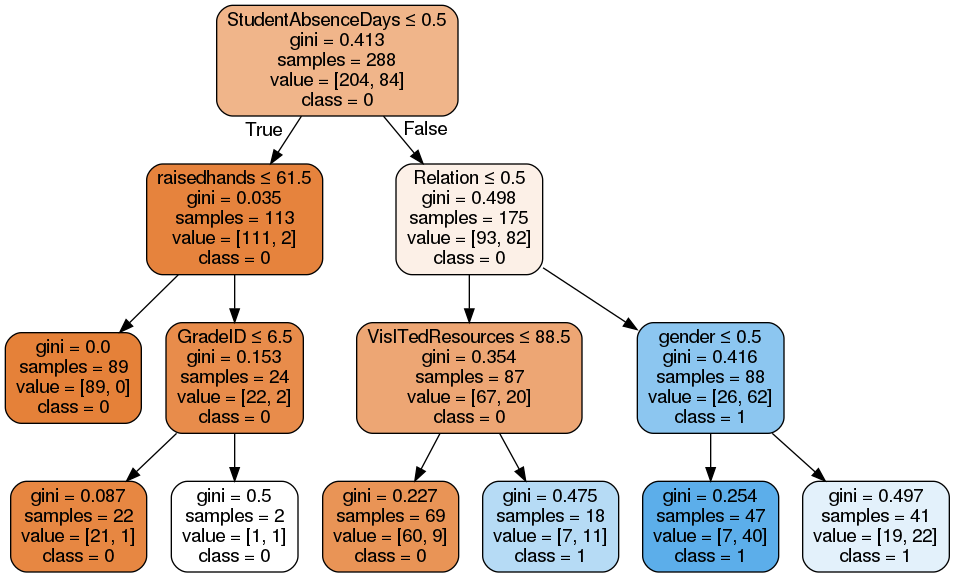

In [304]:
# visualización del mejor árbol
trees = combinations[1]
dot_data = StringIO()
export_graphviz(trees['gini'][3], out_file=dot_data, filled=True, 
                rounded=True,special_characters=True,
               feature_names=df.columns, class_names=['0','1'])
graph1 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph1.create_png())

3. Tratamiento de datos faltantes. Probar las siguientes alternativas para completar los datos faltantes:

    - Moda: se rellena el dato faltante con la moda del atributo.
    - Moda de clase: se rellena el dato faltante con la moda del atributo según la clase.
    
    La función para implementación de datos faltantes deberá tomar como parámetros de entrada el dataset, el porcentaje de faltantes y la estrategia de relleno. La salida generará los datos de entrada con los datos faltantes rellenados correspondientemente. Si el dataset utilizado no contiene datos faltantes, generarlos adrede.
    
    Construir una familia de datasets agregando datos faltantes para cada estrategia de relleno sobre el 80% de los datos desarrollo. Preservar un 20% sin alterar para las corridas de validación. Variar desde 0% a 80% en intervalos de 5%.
    
    a) Ejecutar corridas del mejor método del punto 2 para cada familia.
    
    b) Graficar el tamaño del árbol en función del porcentaje de faltantes.
    
    c) Graficar la performance (en Accuracy) en función del porcentaje de faltantes. Utilizar el 20% de datos inalterados para validación.
    
    d) Analizar el tratamiento de datos faltantes de las distintas estrategias sobre los resultados obtenidos.

Se diseña una función llamada generate_na que genera valores NaN en un atributo de un dataframe.
Se diseña también una función fill_na que llama a generate_na, genera faltantes en un dataframe y luego los rellena con la moda de ese atributo o con la moda de ese atributo según la clase.

In [305]:
# se divide el desarrollo en un conjungo de entrenamiento y otro de validación
training_X, validation_X, training_y, validation_y = train_test_split(desarrollo_X, desarrollo_y, 
                                                        train_size=0.8,
                                                        test_size=0.2,
                                                        random_state=123)

In [306]:
# función que genera datos faltantes en un atributo de un dataframe
# toma como parámetros el dataframe al cual se le generarán los faltantes, el atributo para ello y el porcentaje
# de faltantes a generar
def generate_na(dataframe, attribute, percentage):
    df_na = deepcopy(dataframe)
    na_index = df_na[attribute].sample(frac=percentage, random_state=123)
    df_na.loc[na_index.index, attribute] = np.nan
    return df_na

In [307]:
df_target = deepcopy(df)

In [308]:
df_target['Class'] = y

In [309]:
# función imputa datos faltantes con la moda o la moda por atributo según la estrategia elegida
# toma como parámetros el dataframe para rellenar los datos faltantes, el atributo donde se generarán y luego
# se rellenarán los datos faltantes y la estrategia de relleno
def fill_na(dataframe, attribute, percentage, strategy):
    # genera datos faltantes
    df_na = generate_na(dataframe, attribute, percentage)
    # determina cuál será la moda según la estrategia seleccionada
    if strategy == 'mode':
        moda = dataframe.iloc[:,:len(dataframe.columns)-1].mode()
        moda = list(moda.loc[:, attribute])
        # se eliminan los NaN que se hayan generado en el caso de que algún atributo presente más de una moda
        while math.isnan(moda[-1]):
            del moda[-1]
        # si hay una sola moda, se imputan los datos faltantes con ella
        if len(moda) == 1:
            df_fill = df_na.fillna({attribute:moda[0]})
        # si hay más de una, se imputa el 50% de los datos faltantes con una moda y el otro 50% con la otra
        elif len(moda) == 2:
            moda = mean(moda)
            df_fill = df_na.fillna({attribute:moda})
    elif strategy == 'mode_by_class':
        moda = df_target.groupby(['Class']).agg(lambda x:x.value_counts().index[0])
        moda = moda.loc[:, [attribute]]
        df_fill = deepcopy(df_na)
        for i in moda.index:
            df_fill.loc[(df_fill[attribute].isna())&(df_fill['Class']==i),attribute]= moda.loc[i,attribute]
    # warning en caso que no se seleccione una estrategia posible
    else:
        print('Select "mode" or "mode_by_class".')
    return df_fill.drop(columns=['Class'])

Construcción de la familia de datasets. Se agregan datos faltantes para cada estrategia de relleno sobre el 80% de los datos desarrollo. Se preserva un 20% sin alterar para las corridas de validación. 
Se varía desde 0% a 80% en intervalos de 5% para construir la familia de datasets.

Los datos de training y validación son los mismos que los utilizados en la consigna 2.2 dado que respetan las mismas proporciones

In [310]:
# función que genera 2 familias de datasets con datos faltantes variando desde 0% a 80% en intervalos de 5%
# a una familia la rellena con la moda y a otra, con la moda por clase
# toma como input un df sobre el que se generan los datos faltantes, el atributo para hacerlo y la/s estrategia/s
# de relleno
# devuelve un diccionario con cada familia de dataset agrupada por estrategia de relleno 
def generate_ds_family(df_training, df_target, attribute, strategies_list):
    datasets_moda = dict()
    complete_dataset = deepcopy(df_training)
    complete_dataset['Class'] = df_target
    # para cada estrategia e
    for e in strategies_list:
        # se establece i=0
        i=0
        # se genera una key en el diccionario con el nombre de la estrategia
        datasets_moda[e]=dict()
        # mientras i sea menor o igual a 0.8
        while i <= 0.81:
            # se rellenan los datos del dataset y el atributo indicados con el porcentage i y la estrategia e
            d = fill_na(complete_dataset, attribute, i, e)
            # se agrega el nuevo dataset a la lista de datasets_moda
            datasets_moda[e][round(i,2)] = d
            # se incrementa i en 0.05
            i += 0.05
    return datasets_moda

In [311]:
# se instancia la función generate_ds_family con el training_X3 y el atributo y las estrategias deseadas
# para la generación e imputación de faltantes
datasets_families = generate_ds_family(training_X,training_y, 'raisedhands',strategies_list=['mode', 'mode_by_class'])

In [312]:
# visualización del primer dataset generado para la familia moda
datasets_families['mode'][0].head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,raisedhands,VisITedResources,AnnouncementsView,Discussion
115,1,4,4,2,0,1,7,0,0,1,1,0,0.0,8,11,70
348,1,5,5,2,0,1,4,0,1,0,1,0,20.0,3,9,3
305,0,3,3,2,1,1,10,1,0,1,0,1,32.0,44,29,89
71,1,4,4,1,4,0,7,0,0,1,1,1,29.0,22,9,20
420,0,3,3,1,5,0,2,0,1,1,1,1,82.0,89,22,31


a) Se ejecutan corridas de un árbol de decisión de altura 3 con Gini Gain para cada familia.

In [313]:
corridas = dict()
for family in datasets_families:
    print('Entrenando familia de datasets imputados con la estrategia ' + family)
    corridas[family]=dict()
    i = 0
    for d in datasets_families[family].keys():
        # entrenamiento del árbol
        dtree = DecisionTreeClassifier(max_depth=3, criterion='gini')
        dtree.fit(datasets_families[family][d], training_y)
        corridas[family][round(i,2)]=dtree
        i += 0.05
print('Entrenamientos almacenados en corridas')

Entrenando familia de datasets imputados con la estrategia mode
Entrenando familia de datasets imputados con la estrategia mode_by_class
Entrenamientos almacenados en corridas


In [314]:
#corrida

b) Se grafica el tamaño de los árboles en función del porcentaje de faltantes para cada estrategia de reemplazo.

In [315]:
moda_faltantes = list()
moda_tamaño = list()
por_clase_faltantes = list()
por_clase_tamaño = list()

for dataset in corridas['mode'].keys():
    dtree = corridas['mode'][dataset]
    moda_faltantes.append(dataset)
    moda_tamaño.append(dtree.tree_.node_count)
    
for dataset in corridas['mode_by_class'].keys():
    dtree = corridas['mode_by_class'][dataset]
    por_clase_faltantes.append(dataset)
    por_clase_tamaño.append(dtree.tree_.node_count)

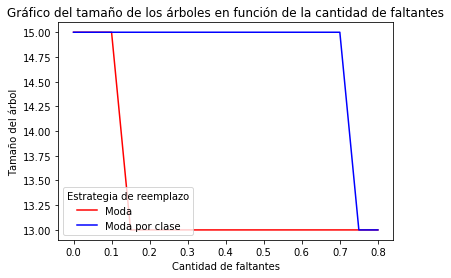

In [316]:
plt.plot(moda_faltantes, moda_tamaño, 'r', label='Moda')
plt.plot(por_clase_faltantes, por_clase_tamaño, 'b', label='Moda por clase')
plt.xlabel('Cantidad de faltantes')
plt.ylabel('Tamaño del árbol')
plt.title('Gráfico del tamaño de los árboles en función de la cantidad de faltantes')
plt.legend(title='Estrategia de reemplazo', loc='lower left')
plt.show()

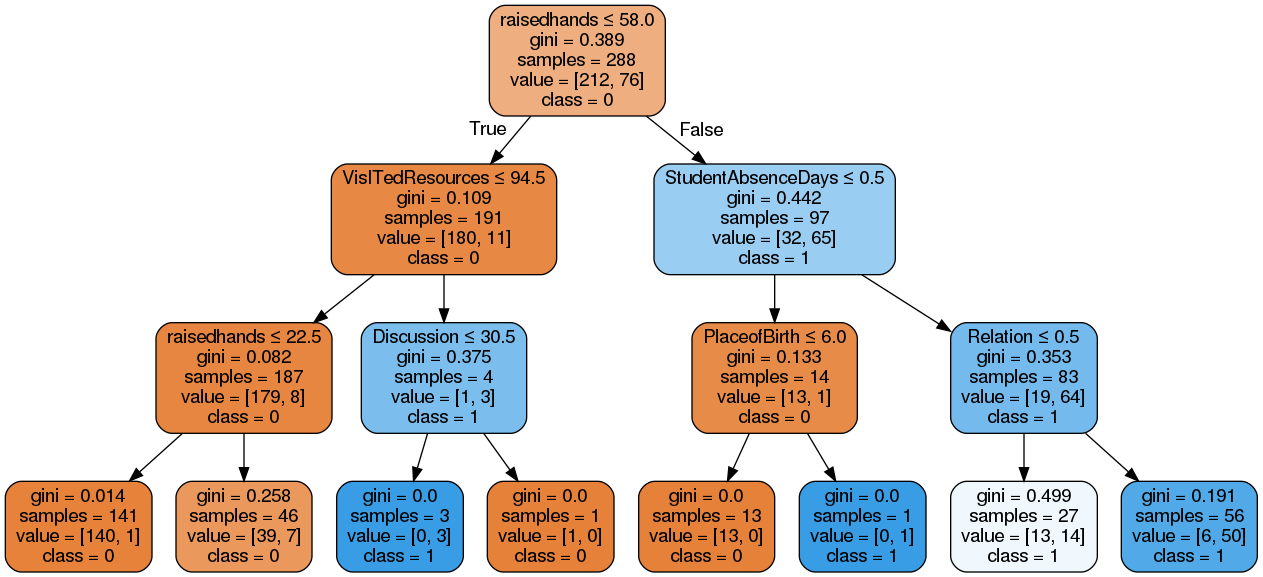

In [317]:
# visualización de árboles
dot_data = StringIO()
export_graphviz(corridas['mode_by_class'][0.35], out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=training_X.columns, class_names=['0','1'])
graph1 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph1.create_png())

c) Se grafica la performance (en Accuracy) en función del porcentaje de faltantes para cada estrategia de reemplazo. Se utilizar el 20% de datos inalterados para validación.

In [318]:
moda_accuracy = list()
por_clase_accuracy = list()

for dataset in corridas['mode'].keys():
    dtree = corridas['mode'][dataset]
    predictions=dtree.predict(validation_X)
    acc=accuracy_score(validation_y, predictions)
    moda_accuracy.append(acc)
    
for dataset in corridas['mode_by_class'].keys():
    dtree = corridas['mode_by_class'][dataset]
    predictions=dtree.predict(validation_X)
    acc=accuracy_score(validation_y, predictions)
    por_clase_accuracy.append(acc)

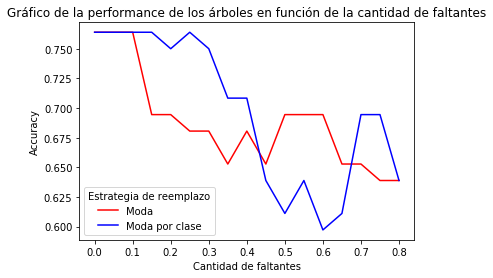

In [319]:
plt.plot(moda_faltantes, moda_accuracy, 'r', label='Moda')
plt.plot(por_clase_faltantes, por_clase_accuracy, 'b', label='Moda por clase')
plt.xlabel('Cantidad de faltantes')
plt.ylabel('Accuracy')
plt.title('Gráfico de la performance de los árboles en función de la cantidad de faltantes')
plt.legend(title='Estrategia de reemplazo', loc='lower left')
plt.show()

d) Analizar el tratamiento de datos faltantes de las distintas estrategias sobre los resultados obtenidos.

4. Tolerancia al ruido. Se deberá implementar una función que introduzca ruido (cambio de un valor) sobre un atributo numérico.Para este experimento se deberá implementar una función ind_ruido, que toma como parámetros de entrada el dataset y el porcentaje de ruido a introducir sobre la clase. 

In [320]:
def ind_ruido(db, porc_ruido, num_columna):
    dh = deepcopy(db)
    mat = db.iloc[:,num_columna].values
    prop = int(mat.size * porc_ruido)
    vec = random.sample(range(len(mat)), prop)
    for i in range (len(vec)):
        mat[vec[i]]=np.random.uniform(101,999)
    dh.iloc[:,num_columna] = mat
    return dh

In [321]:
#data.head()

In [322]:
#list(data)

    a) Construir una familia de datasets generando ruido. Preservar un 20% sin alterar para las corridas de validación. Variar desde 0% a 35% en intervalos de 5% el atributo elegido.

In [323]:
training_X2 = deepcopy(training_X)
validation_X2 = deepcopy(validation_X)

In [324]:
list(training_X2)

['gender',
 'NationalITy',
 'PlaceofBirth',
 'StageID',
 'GradeID',
 'SectionID',
 'Topic',
 'Semester',
 'Relation',
 'ParentAnsweringSurvey',
 'ParentschoolSatisfaction',
 'StudentAbsenceDays',
 'raisedhands',
 'VisITedResources',
 'AnnouncementsView',
 'Discussion']

In [325]:
training_X.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,raisedhands,VisITedResources,AnnouncementsView,Discussion
115,1,4,4,2,0,1,7,0,0,1,1,0,0,8,11,70
348,1,5,5,2,0,1,4,0,1,0,1,0,20,3,9,3
305,0,3,3,2,1,1,10,1,0,1,0,1,32,44,29,89
71,1,4,4,1,4,0,7,0,0,1,1,1,29,22,9,20
420,0,3,3,1,5,0,2,0,1,1,1,1,82,89,22,31


In [326]:
# crea la familia de datasets con el ruido en un diccionario
d = dict()
i=0
while i <=0.35:
    d[round(i,2)] = ind_ruido(training_X2,i,12)
    i+=0.05    

In [327]:
list(d.keys())

[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

    b) Ejecutar corridas del mejor método del punto 2.2 para cada familia.

In [328]:
#Se ejecutan corridas de un árbol de decisión de altura 3 con Gini Gain para cada dataset con ruido.
arboles = dict()
for k in d.keys():
        dtree = DecisionTreeClassifier(max_depth=3, criterion='gini')
        dtree = dtree.fit(d[k], training_y)
        arboles[k]=dtree
        y_pred = dtree.predict(validation_X2)
        print("Accuracy porcentaje de ruido {0:4}: {1}".format(k,accuracy_score(validation_y, y_pred)))

Accuracy porcentaje de ruido    0: 0.7638888888888888
Accuracy porcentaje de ruido 0.05: 0.7083333333333334
Accuracy porcentaje de ruido  0.1: 0.6944444444444444
Accuracy porcentaje de ruido 0.15: 0.6944444444444444
Accuracy porcentaje de ruido  0.2: 0.6944444444444444
Accuracy porcentaje de ruido 0.25: 0.6944444444444444
Accuracy porcentaje de ruido  0.3: 0.6944444444444444
Accuracy porcentaje de ruido 0.35: 0.6944444444444444


    c) Graficar el tamaño del árbol en función del porcentaje de ruido.

In [329]:
#arboles

In [330]:
ruido_faltantes = list()
ruido_tamaño = list()

for k in arboles.keys():
    ruido_faltantes.append(k)
    ruido_tamaño.append(arboles[k].tree_.node_count)

In [331]:
#ruido_faltantes

In [332]:
#ruido_tamaño

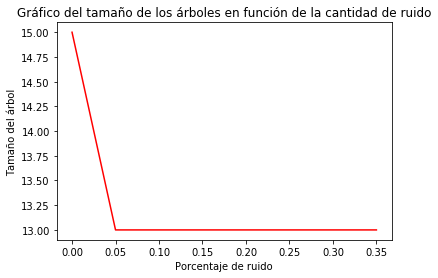

In [333]:
plt.plot(ruido_faltantes, ruido_tamaño, 'r', label='Ruido')
plt.xlabel('Porcentaje de ruido')
plt.ylabel('Tamaño del árbol')
plt.title('Gráfico del tamaño de los árboles en función de la cantidad de ruido')
plt.show()

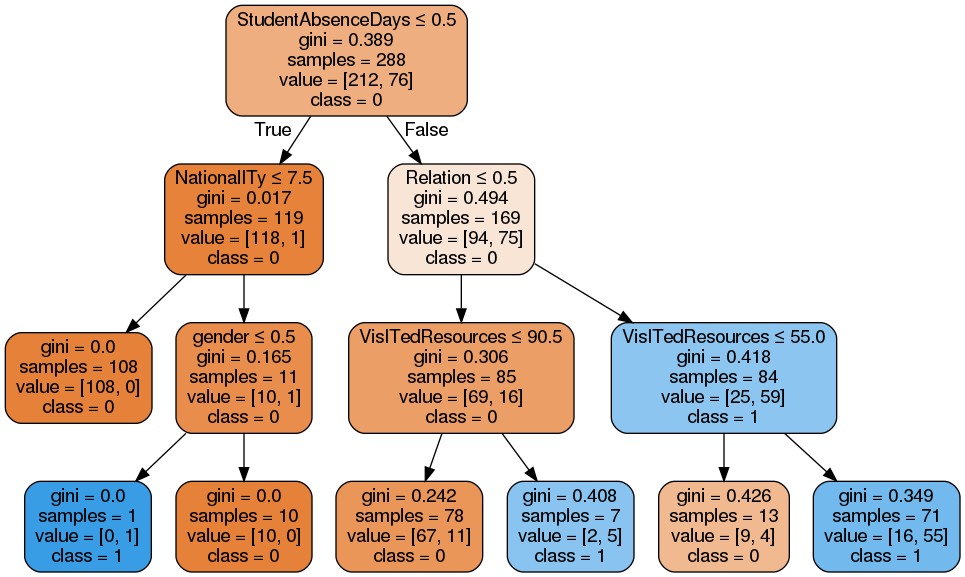

In [334]:
#Hacemos el gráfico del último árbol para ver si está bien lo de 15 nodos en todos
dot_data = StringIO()
export_graphviz(arboles[0.35], out_file=dot_data, filled=True, rounded=True,special_characters=True,
               feature_names=training_X2.columns, class_names=['0','1'])
graph1 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph1.create_png())

    d) Graficar la performance en función del porcentaje de ruido. Utilizar el 20% de datos inalterados para validación.

In [335]:
ruido_accuracy = list()

for k in arboles.keys():
    y_pred = arboles[k].predict(validation_X2)
    acc=accuracy_score(validation_y, y_pred)
    ruido_accuracy.append(acc)

In [336]:
#ruido_accuracy

In [337]:
#ruido_faltantes

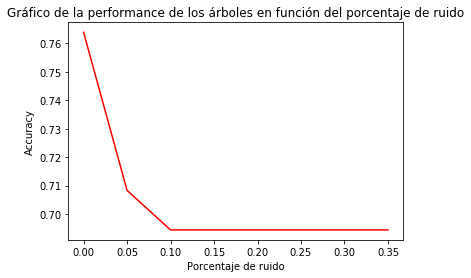

In [338]:
plt.plot(ruido_faltantes, ruido_accuracy, 'r', label='Ruido')
plt.xlabel('Porcentaje de ruido')
plt.ylabel('Accuracy')
plt.title('Gráfico de la performance de los árboles en función del porcentaje de ruido')
plt.show()

    e) Analizar la tolerancia al ruido sobre los resultados obtenidos.

## 3. Naive Bayes

Ejecutar Naive Bayes, informar las probabilidades condicionales y previas. Realizar las validaciones correspondientes.

In [339]:
# función que convierte los valores de las columnas con atributos numéricos en categóricos
def convert_columns(dataset):
    col1 = pd.cut(dataset['raisedhands'], 3, labels=False)
    dataset['raisedhands'] = col1
    col2 = pd.cut(dataset['VisITedResources'], 3, labels=False)
    dataset['VisITedResources'] = col2
    col3 = pd.cut(dataset['AnnouncementsView'], 3, labels=False)
    dataset['AnnouncementsView'] = col3
    col4 = pd.cut(dataset['Discussion'], 3, labels=False)
    dataset['Discussion'] = col4
    return dataset

In [340]:
# función que toma cada fold separado para acer 5-fold cross validation y convierte las columnas
# con atributos numéricos en columnas con atributos categóricos mediante un proceso de discretización
def numerical2categorical(fold_list):
    categorical_folds = list()
    for fold in fold_list:
        new_fold = dict()
        training_X = deepcopy(fold['training_X'])
        validation_X = deepcopy(fold['validation_X'])
        new_fold['training_X'] = convert_columns(training_X)
        new_fold['validation_X'] = convert_columns(validation_X)
        new_fold['training_y'] = fold['training_y']
        new_fold['validation_y'] = fold['validation_y']
        categorical_folds.append(new_fold)
    return categorical_folds

In [341]:
folds4bayes = numerical2categorical(folds)

In [342]:
# función que implementa Naive Bayes sobre un conjunto de folds haciendo cross validation
def naive_bayes(fold_list):
    mean_acc = list()
    mean_roc = list()
    i = 1
    for fold in fold_list:
        # entrena un modelo de Naive Bayes con el set de entrenamiento
        gnb = GaussianNB() 
        gnb.fit(fold['training_X'], fold['training_y'])
        target_pred = gnb.predict(fold['validation_X'])
        # Evalúa la cantidad de puntos mal clasificados
        print('----- FOLD %d -----' % (i))
        print("Cantidad de puntos mal clasificados del total de %d puntos: %d" 
              % (fold['training_X'].shape[0],(fold['validation_y']!=target_pred).sum()))
        # Mide el accuracy obtenido sobre los datos de validación
        acc=accuracy_score(fold['validation_y'], target_pred)
        roc_auc=roc_auc_score(fold['validation_y'], target_pred)  #mide accuracy
        print('El accuracy es de:', acc)
        print('El ROC AUC Score es de:', roc_auc)
        mean_acc.append(acc)
        mean_roc.append(roc_auc)
        i += 1
    print('==== PROMEDIO ====')
    print('El promedio de accuracy es:', mean(mean_acc))
    print('El promedio del score ROC AUC es:', mean(mean_roc))

In [343]:
naive_bayes(folds4bayes)

----- FOLD 1 -----
Cantidad de puntos mal clasificados del total de 288 puntos: 15
El accuracy es de: 0.7916666666666666
El ROC AUC Score es de: 0.812340425531915
----- FOLD 2 -----
Cantidad de puntos mal clasificados del total de 288 puntos: 10
El accuracy es de: 0.8611111111111112
El ROC AUC Score es de: 0.8576923076923078
----- FOLD 3 -----
Cantidad de puntos mal clasificados del total de 288 puntos: 15
El accuracy es de: 0.7916666666666666
El ROC AUC Score es de: 0.8240740740740741
----- FOLD 4 -----
Cantidad de puntos mal clasificados del total de 288 puntos: 11
El accuracy es de: 0.8472222222222222
El ROC AUC Score es de: 0.8081232492997199
----- FOLD 5 -----
Cantidad de puntos mal clasificados del total de 288 puntos: 13
El accuracy es de: 0.8194444444444444
El ROC AUC Score es de: 0.8165266106442577
==== PROMEDIO ====
El promedio de accuracy es: 0.8222222222222222
El promedio del score ROC AUC es: 0.8237513334484549


Cálculo de probabilidades previas y condicionales

Calculamos las probabilidades sobre un set de entrenamiento de los 5 contenidos en el conjunto de folds.

In [344]:
data = folds4bayes[0]

In [345]:
data_target = pd.concat([data['training_X'], data['training_y']], axis=1, join_axes=[data['training_X'].index])

In [346]:
# calcula la probabilidad previa (Probabilidad de 1 o 0)

rating_probs = data_target.groupby('Class').size().div(len(data_target))
print("Probabilidad previa de", rating_probs)

Probabilidad previa de Class
0    0.722222
1    0.277778
dtype: float64


In [347]:
# calcula la probabilidad condicional
columns = data_target.columns

for i in range(len(columns)-1):
    prob_cond = data_target.groupby([columns[i],'Class']).size().div(len(data_target)).div(rating_probs,axis=0,level='Class')
    print(prob_cond)

gender  Class
0       0        0.298077
        1        0.587500
1       0        0.701923
        1        0.412500
dtype: float64
NationalITy  Class
0            0        0.014423
             1        0.012500
1            0        0.014423
2            0        0.033654
             1        0.062500
3            0        0.336538
             1        0.400000
4            0        0.423077
             1        0.262500
5            0        0.024038
6            0        0.014423
7            0        0.038462
             1        0.062500
8            0        0.019231
             1        0.050000
9            0        0.024038
             1        0.025000
10           0        0.033654
             1        0.025000
11           0        0.009615
             1        0.025000
12           0        0.014423
             1        0.062500
13           1        0.012500
dtype: float64
PlaceofBirth  Class
0             0        0.009615
              1        0.012500
1    

## 4. Comparación de algoritmos

Comparar Naive Bayes y árboles de decisión. Para hacerlo usar 5-fold cross-validation para la exploración de la mejor solución en cada caso. En árboles de decisión determinar qué tamaño de árbol conviene y si conviene utilizar Gini o Information Gain (todo esto con el conjunto de desarrollo y utilizando grid search). Utilizar ROC AUC como métrica. Testear ambos algoritmos con el conjunto de test independiente (mismo conjunto de test en ambos casos).

Se determina qué parámetros (tamaño, gini o gain) para árboles de decisión conviene usar utilizando el método de Grid Search con el conjunto de desarrollo completo (train y validación).

In [348]:
parameters = {'criterion':['gini','entropy'], 'max_leaf_nodes':list(range(5,20))}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
clf.fit(X=desarrollo_X, y=desarrollo_y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.8472222222222222 {'criterion': 'gini', 'max_leaf_nodes': 8}


Se entrena un árbol de decisión con criterio Gini tamaño de nodos 8.

In [349]:
dtree = DecisionTreeClassifier(max_leaf_nodes=8, criterion='gini')
dtree.fit(desarrollo_X, desarrollo_y)
tree_predictions = dtree.predict(heldout_X)
tree_auc = roc_auc_score(heldout_y, tree_predictions)
print('Score ROC AUC para árbol de decisión testeado con Held Out', tree_auc)

Score ROC AUC para árbol de decisión testeado con Held Out 0.8106479973949854


Se entrena un arlgoritmo de Naive Bayes y se lo compara con el score obtenido en el árbol de decisión. Previamente se pasan las variables numéricas a variables categóricas.

In [350]:
gnb_desarrollo_X = deepcopy(desarrollo_X)
gnb_desarrollo_X = convert_columns(gnb_desarrollo_X)

In [351]:
gnb_heldout_X = deepcopy(heldout_X)
gnb_heldout_X = convert_columns(gnb_heldout_X)

In [352]:
gnb = GaussianNB()   #Modelo NB
gnb.fit(gnb_desarrollo_X, desarrollo_y)
gnb_predictions = gnb.predict(gnb_heldout_X)  # ajusta a los datos
gnb_auc=roc_auc_score(heldout_y, gnb_predictions)  #mide accuracy
print('Score ROC AUC para Naive Bayes testeado con Held Out', gnb_auc)

Score ROC AUC para Naive Bayes testeado con Held Out 0.7955063497232172


Se grafica el árbol de decisión entrenado.

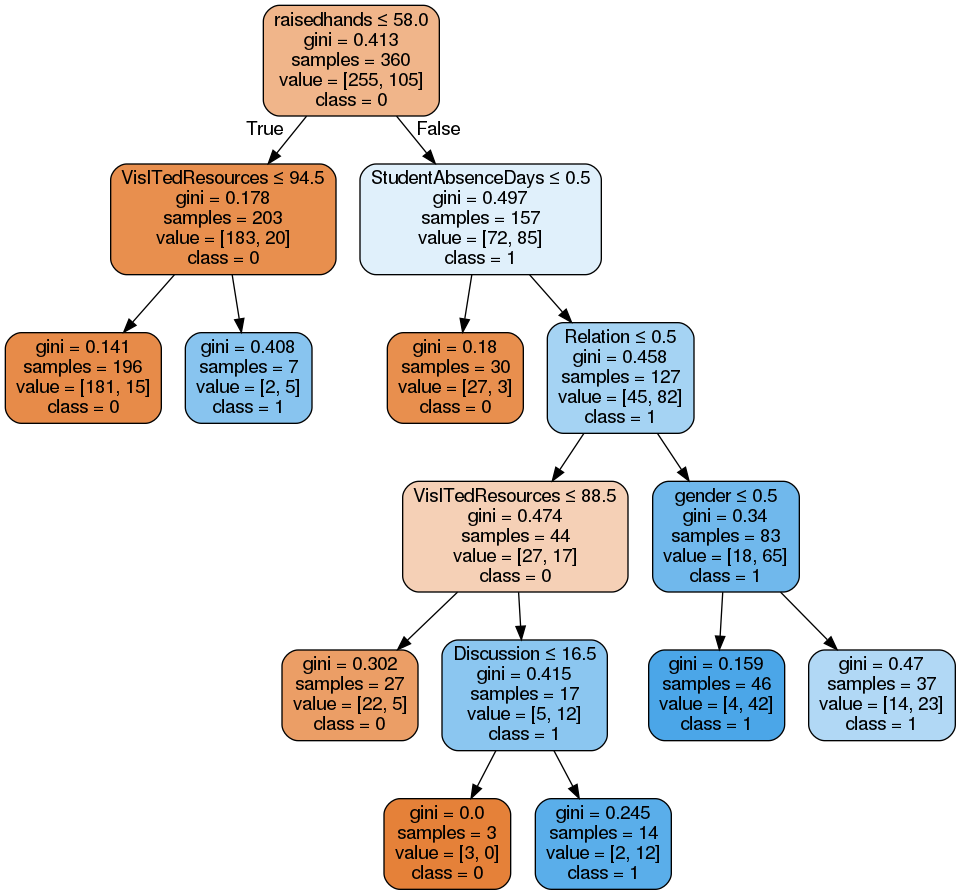

In [353]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, filled=True, rounded=True,special_characters=True,
               feature_names=training_X2.columns, class_names=['0','1'])
graph1 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph1.create_png())

# Anexo

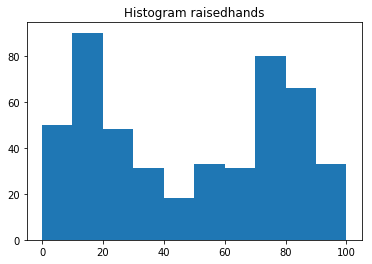

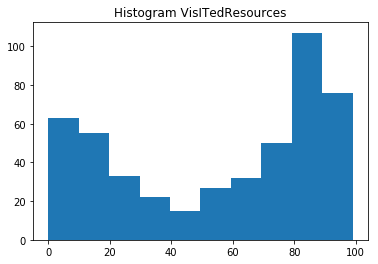

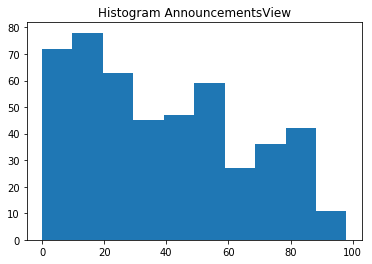

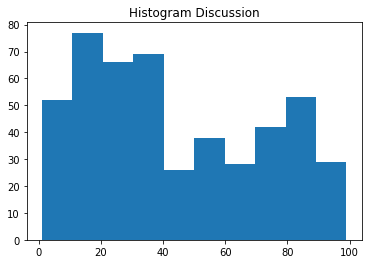

In [354]:
# histogramas para ver cómo particionar los datos de manera categórica en el punto 3 de Naive Bayes
import matplotlib.pyplot as plt

plt.hist(df.raisedhands, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram raisedhands")
plt.show()

plt.hist(df.VisITedResources, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram VisITedResources")
plt.show()

plt.hist(df.AnnouncementsView, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram AnnouncementsView")
plt.show()

plt.hist(df.Discussion, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram Discussion")
plt.show()